# Uncertainty Learning with MNIST

In this notebook we use the `uncertainty-loss` package to train some models on the MNIST dataset.  We then compare this to training with traditional cross entropy loss to see how the model perform in terms of accuracy and uncertainty quantification both for in-distribution and out-of-distribution data.

In [1]:
import pathlib
import sys 
from collections import defaultdict
import warnings
import os 

# force reproduciblity
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import torch
from torch import nn 
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision 
import torchvision.transforms.functional as TF
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
import pandas as pd 

import uncertainty_loss as ul

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# force reproduciblity
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms(True)


print('python version:', sys.version)
print('torch version:', torch.__version__)
print('device:', DEVICE)

%load_ext autoreload
%autoreload 2

python version: 3.9.5 (default, Jun  4 2021, 12:28:51) 
[GCC 7.5.0]
torch version: 1.12.1+cu102
device: cuda


------
# Load the MNIST data set

In [2]:
mnist_train = torchvision.datasets.MNIST("./data/", download=True, transform=torchvision.transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST("./data/", train=False, download=True, transform=torchvision.transforms.ToTensor())

train_dl = DataLoader(mnist_train, batch_size=1000, shuffle=True)
test_dl = DataLoader(mnist_test, batch_size=1000, shuffle=False)

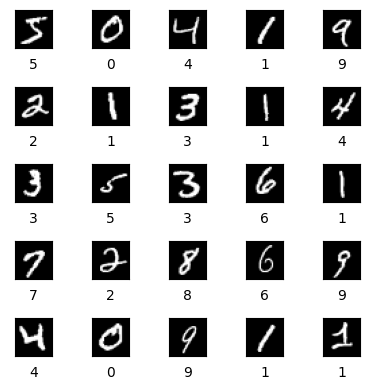

In [3]:
def plot_examples(examples:list, grid=5):
    """Plots a list of images together with their label."""
    fig, axes = plt.subplots(grid,grid, figsize=(4,4))
    for i,ax in enumerate(axes.ravel()):
        ax.imshow(examples[i][0][0], cmap='gray')
        ax.set_xlabel(examples[i][1], fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
    fig.tight_layout()
    fig.set_facecolor('white')
    return fig, ax 

fig,ax = plot_examples([mnist_train[i] for i in range(25)], grid=5)
    
    

-------
# Set up model

We use a simple LeNet CNN to train against the MNIST dataset.

In [4]:
class LeNet(torch.nn.Module):
    r"""LeNet convoluational architecture."""

    def __init__(self, kernel_size=5, d_hidden=500, activation=F.relu, dropout=.3, classifier_activation=None):
        """Initialize a LeNet instance.
        
        Args:
            filter_size: 
            activation:
        """
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=kernel_size)
        self.conv2 = nn.Conv2d(20,50, kernel_size=kernel_size)
        self.max_pool = nn.MaxPool2d(1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(20000, d_hidden)
        self.fc2 = nn.Linear(d_hidden, 10)
        self.activation=activation
        self.dropout = nn.Dropout(dropout)
        self.classifier_activation = classifier_activation

    def forward(self, x:torch.Tensor):
        """Run a forward pass of the model."""
        x = self.activation(self.max_pool(self.conv1(x)))
        x = self.activation(self.max_pool(self.conv2(x)))
        x = self.flatten(x)
        x = self.dropout(self.activation(self.fc1(x)))
        x = self.fc2(x)
        if self.classifier_activation is not None:
            x = self.classifier_activation(x)
        return x

------
# Training code

We now write a simple pure pytorch fit loop. We really only care about having a trained model so we won't worry too much about optimizing it for now.  Instead we want to train 3 models each with a different loss function 

* evidential_loss
* maxnorm_loss
* cross_entropy

The first 2 are uncertainty loss functions that help quantify uncertainty, the last is traditional cross entropy loss.  Note that the uncertainty loss functions have an optional `reg_factor` argument.  It is recommended to slowly increase the reg_factor throughout training.  See the training loop below for an example of how to do that.  

In [5]:
def mnist_fit_loop(model, criterion, reg_factor=None, epochs=10):
    """Train a model on the MNIST dataset."""
    model.to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5, verbose=True, factor=0.2, min_lr=1e-6)
    reg_step = 1/500 # saturate after 500 steps
    for epoch in range(epochs):
        model.train()
        for i, (x,y) in enumerate(train_dl):
            opt.zero_grad()
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            out = model(x)
            if reg_factor is not None:
                loss = criterion(out, y, reg_factor=reg_factor)
                reg_factor = min(reg_factor + reg_step, 1)
            else:
                loss = criterion(out, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            if i == len(train_dl)-1:
                end = " " 
            else:
                end = "\r"
            print(f"Epoch {epoch} batch {i} loss {loss.item():.3f}", end=end)

        print("", end='')
        model.eval()
        with torch.no_grad():
            if reg_factor is None:
                val_loss = sum(criterion(model(x.to(DEVICE)), y.to(DEVICE))
                            for x,y in test_dl)
            else:
                val_loss = sum(criterion(model(x.to(DEVICE)), y.to(DEVICE), reg_factor=reg_factor)
                            for x,y in test_dl)
            val_loss = val_loss / len(test_dl)
        
        if reg_factor is not None:
            print(f"test_loss {val_loss:.3f}, reg_factor {reg_factor:.3f}")
        else:
            print(f"test_loss {val_loss:.3f}")
        
        lr_scheduler.step(val_loss)



------
# Train with Evidential Uncertainty

We train a model with `evidential_loss` from the paper [Evidential Deep Learning to Quantify Classification Uncertainty
](https://arxiv.org/abs/1806.01768).  Recall that our fit loop takes a loss function as a parameter so we just simply pass in `ul.evidental_loss`

**Important** The evidential loss functions expect **non-negative** inputs.  To accomplish this we add an activation to the last layer of the network.  Any non-negative transformation will work but we've found that `exp` works well (so did the authors of the original papers).  We provide a convenience function `clamped_exp` for clamping the raw logits before `exp` to avoid over/under flow.

In [6]:
models = {}
torch.manual_seed(0)

# need outputs to be non-negative so we add an exp activation to the last layer
model = LeNet(classifier_activation=ul.clamped_exp) 
print('Training Evidential Uncertainty Model')
print('='*80)
mnist_fit_loop(model, ul.evidential_loss, reg_factor=0.0)
models['evidential'] = model

Training Evidential Uncertainty Model
Epoch 0 batch 59 loss 0.089 test_loss 0.082, reg_factor 0.120
Epoch 1 batch 59 loss 0.089 test_loss 0.057, reg_factor 0.240
Epoch 2 batch 59 loss 0.063 test_loss 0.057, reg_factor 0.360
Epoch 3 batch 59 loss 0.075 test_loss 0.059, reg_factor 0.480
Epoch 4 batch 59 loss 0.060 test_loss 0.071, reg_factor 0.600
Epoch 5 batch 59 loss 0.052 test_loss 0.064, reg_factor 0.720
Epoch 6 batch 59 loss 0.051 test_loss 0.058, reg_factor 0.840
Epoch 7 batch 59 loss 0.035 test_loss 0.070, reg_factor 0.960
Epoch 00008: reducing learning rate of group 0 to 2.0000e-04.
Epoch 8 batch 59 loss 0.021 test_loss 0.062, reg_factor 1.000
Epoch 9 batch 59 loss 0.015 test_loss 0.067, reg_factor 1.000


Now lets see how accurate our model is on the test set.

In [7]:
model = models['evidential']
with torch.no_grad():
    y_pred = torch.stack([torch.argmax(model(x.to(DEVICE)),dim=-1) for x,y in test_dl])
    y_true = torch.stack([y.to(DEVICE) for x,y in test_dl])
acc = torch.mean((y_pred == y_true).float()).item()
print(f'Evidential Accuracy: {acc:.2%}')

Evidential Accuracy: 99.16%


Great, so our model is 99% accurate and it was trained with evidential uncertainty loss so it should be good at figuring out when it is uncertain about bad inputs. 

### Out of distribution data
Let's test this by feeding it images from [fashion mnist](https://github.com/zalandoresearch/fashion-mnist) to see if it is highly uncertain about these inputs.  Ideally it will be because fashion mnist images look very different from mnist images.

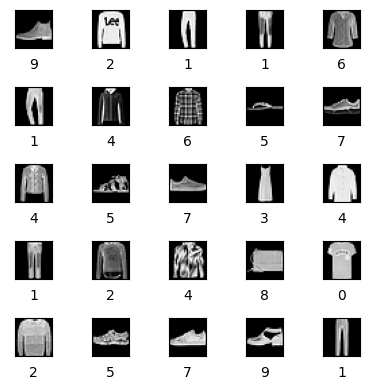

In [8]:
fashion_mnist = torchvision.datasets.FashionMNIST("data", download=True, train=False, transform=torchvision.transforms.ToTensor())
fashion_mnist_dl = DataLoader(fashion_mnist, batch_size=1000, shuffle=False)
fig,ax = plot_examples([fashion_mnist[i] for i in range(25)], grid=5)

We see the images are clothing items with class ids for the different types of clothes.  Let's look at the distribution of uncertainty scores for this model on fashion mnist compared to the mnist test set.

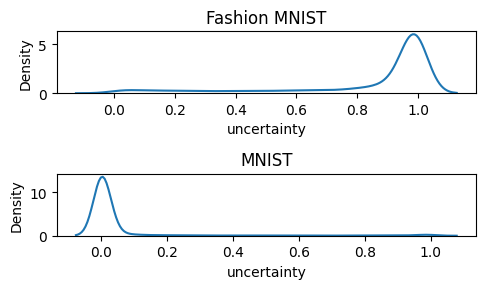

In [9]:
metrics = {}
model = models['evidential']
with torch.no_grad():
    fashion_evidence = torch.cat([model(x.to(DEVICE)) for x,y in fashion_mnist_dl])
    mnist_evidence = torch.cat([model(x.to(DEVICE)) for x,y in test_dl])

fashion_uncert = ul.uncertainty(fashion_evidence, normalize=True).cpu().numpy()
mnist_uncert = ul.uncertainty(mnist_evidence, normalize=True).cpu().numpy()

metrics['evidential'] = {'fashion_uncert':fashion_uncert, 'mnist_uncert':mnist_uncert}

fig,ax = plt.subplots(2,1,figsize=(5,3))
sns.kdeplot(fashion_uncert.ravel(),ax=ax[0])
ax[0].set_title('Fashion MNIST')
sns.kdeplot(mnist_uncert.ravel(),ax=ax[1])
ax[1].set_title('MNIST')
for a in ax:
    a.set_xlabel('uncertainty')
fig.tight_layout()



As we can see, the uncertainty scores for fashion mnist are much higher than for mnist.  This is exactly what we want since fashion mnist is out of distribution - the model was not trained on anything similar, so it the examples should have high uncertainty scores.

------
# Compare with Cross Entropy

We now train a model with traditional cross entropy loss.  We'll compare the raw accuracy of this model with the other models and we will also compare how well each model does at identifying out of distribution data with uncertainty scores.

In [10]:
torch.manual_seed(0)
model = LeNet(classifier_activation=None)
print('Training Standard Cross Entropy Model')
print('='*80)
mnist_fit_loop(model, F.cross_entropy)
models['cross_entropy'] = model

Training Standard Cross Entropy Model
Epoch 0 batch 59 loss 0.056 test_loss 0.064
Epoch 1 batch 59 loss 0.039 test_loss 0.036
Epoch 2 batch 59 loss 0.031 test_loss 0.031
Epoch 3 batch 59 loss 0.041 test_loss 0.029
Epoch 4 batch 59 loss 0.019 test_loss 0.027
Epoch 5 batch 59 loss 0.014 test_loss 0.026
Epoch 6 batch 59 loss 0.010 test_loss 0.026
Epoch 7 batch 59 loss 0.024 test_loss 0.032
Epoch 8 batch 59 loss 0.019 test_loss 0.028
Epoch 9 batch 59 loss 0.007 test_loss 0.029


How accurate is the cross entropy model?

In [11]:
model = models['cross_entropy']
with torch.no_grad():
    y_pred = torch.stack([torch.argmax(model(x.to(DEVICE)),dim=-1) for x,y in test_dl])
    y_true = torch.stack([y.to(DEVICE) for x,y in test_dl])
acc = torch.mean((y_pred == y_true).float()).item()
print(f'Cross Entropy Accuracy: {acc:.2%}')

Cross Entropy Accuracy: 99.13%


Under identical training conditions (including the random seed) the model trained with cross entropy loss has about the same overall performance on the test set.  Let's see if it can quantify uncertainty as well.

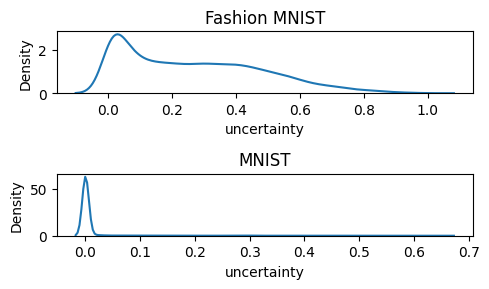

In [12]:
model = models['cross_entropy']
with torch.no_grad():
    fashion_logits= torch.cat([model(x.to(DEVICE)) for x,y in fashion_mnist_dl])
    mnist_logits = torch.cat([model(x.to(DEVICE)) for x,y in test_dl])



fashion_uncert = ul.entropy(F.softmax(fashion_logits, dim=1), normalize=True).cpu().numpy()
mnist_uncert = ul.entropy(F.softmax(mnist_logits, dim=1), normalize=True).cpu().numpy()

metrics['cross_entropy'] = {'fashion_uncert':fashion_uncert, 'mnist_uncert':mnist_uncert}

fig,ax = plt.subplots(2,1,figsize=(5,3))
sns.kdeplot(fashion_uncert.ravel(),ax=ax[0])
ax[0].set_title('Fashion MNIST')
sns.kdeplot(mnist_uncert.ravel(),ax=ax[1])
ax[1].set_title('MNIST')
for a in ax:
    a.set_xlabel('uncertainty')
fig.tight_layout()

Notice for cross entropy the fashion mnist uncertainty scores are weighted towards 0 uncertainty.  This indicates the model is highly certain about completely unfamiliar examples and which it gets 100% of the examples wrong (it can't correctly classify a shoe as a digit!).

-----
# Train MaxNorm Loss

Finally we train one more model with `maxnorm_loss` from the paper [Information Aware Max-Norm Dirichlet Networks for Predictive Uncertainty Estimation](https://arxiv.org/abs/1910.04819).  This follows the same procedure as the `evidential_loss` from above but we include it for completeness.  

### Note
The authors of the paper mention that convergence can be slower with max norm loss and may require more training steps to reach the same degree of accuracy.  We encourage empirical studies of `evidential_loss` and `maxnorm_loss` in particular it would be interesting to know if there are specific hyparparameter ranges that are more ideal for one or the other and in what conditions.  We've found that depending on how each is trained one sometimes out performs the other in terms of OOD detection (with uncertainty scores).  If you have any insightful experiments open a PR to add it to our examples directory!

In [13]:
torch.manual_seed(0)
# need outputs to be non-negative so we add an exp activation to the last layer
model = LeNet(classifier_activation=ul.clamped_exp) 
print('Training MaxNorm Model')
print('='*80)
mnist_fit_loop(model, ul.maxnorm_loss, reg_factor=0.0)
models['maxnorm'] = model

Training MaxNorm Model
Epoch 0 batch 59 loss 0.171 test_loss 0.142, reg_factor 0.120
Epoch 1 batch 59 loss 0.105 test_loss 0.066, reg_factor 0.240
Epoch 2 batch 59 loss 0.058 test_loss 0.055, reg_factor 0.360
Epoch 3 batch 59 loss 0.071 test_loss 0.057, reg_factor 0.480
Epoch 4 batch 59 loss 0.073 test_loss 0.052, reg_factor 0.600
Epoch 5 batch 59 loss 0.071 test_loss 0.059, reg_factor 0.720
Epoch 6 batch 59 loss 0.045 test_loss 0.046, reg_factor 0.840
Epoch 7 batch 59 loss 0.054 test_loss 0.051, reg_factor 0.960
Epoch 8 batch 59 loss 0.042 test_loss 0.049, reg_factor 1.000
Epoch 9 batch 59 loss 0.025 test_loss 0.044, reg_factor 1.000


Lets check the accuracy.

In [14]:
model = models['maxnorm']
with torch.no_grad():
    y_pred = torch.stack([torch.argmax(model(x.to(DEVICE)),dim=-1) for x,y in test_dl])
    y_true = torch.stack([y.to(DEVICE) for x,y in test_dl])
acc = torch.mean((y_pred == y_true).float()).item()
print(f'MaxNorm Accuracy: {acc:.2%}')

MaxNorm Accuracy: 98.88%


This model is little less accurate than the other models.  The authors acknowledge that this loss function may take longer to converge and may also suffer from slight accuracy degradation by being more uncertain near decision boundaries.

Let's check how well it does at OOD detection.

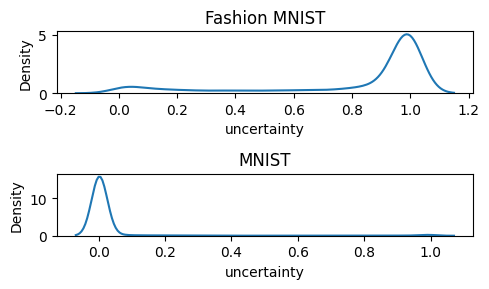

In [15]:
model = models['maxnorm']
with torch.no_grad():
    fashion_evidence= torch.cat([model(x.to(DEVICE)) for x,y in fashion_mnist_dl])
    mnist_evidence = torch.cat([model(x.to(DEVICE)) for x,y in test_dl])



fashion_uncert = ul.uncertainty(fashion_evidence, normalize=True).cpu().numpy()
mnist_uncert = ul.uncertainty(mnist_evidence, normalize=True).cpu().numpy()

metrics['maxnorm'] = {'fashion_uncert':fashion_uncert, 'mnist_uncert':mnist_uncert}

fig,ax = plt.subplots(2,1,figsize=(5,3))
sns.kdeplot(fashion_uncert.ravel(),ax=ax[0])
ax[0].set_title('Fashion MNIST')
sns.kdeplot(mnist_uncert.ravel(),ax=ax[1])
ax[1].set_title('MNIST')
for a in ax:
    a.set_xlabel('uncertainty')
fig.tight_layout()

In this case it looks like the model trained with `maxnorm_loss` has a large peak around the maximum uncertainty which is good.  However there does seem to be another small peak around 0 uncertainty, which is bad, these examples are from a completely different dataset then the one the model was trained on, it should be highly uncertain about all of them!

-----
# OOD Detection

If we choose an uncertainty threshold we can classify as an example as "uncertain" or "certain".  If we do this for fashion mnist, what percent of data points will be certain?

In [16]:
def ood_uncertainty_bar_plot(metrics, threshold=0.5):
    fig,ax = plt.subplots(1,1,figsize=(5,4))
    sns.set_style('whitegrid')
    names = list(metrics.keys())
    percent_certain =[]
    for name in names:
        certain = metrics[name]['fashion_uncert'] < threshold
        percent_certain.append(np.mean(certain))
    
    sns.barplot(x=names, y=percent_certain, color='b')
    ax = plt.gca()
    ax.set_ylabel('Percent Certain')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_title(f'Percent of OOD at least {1-threshold:.0%} certain')


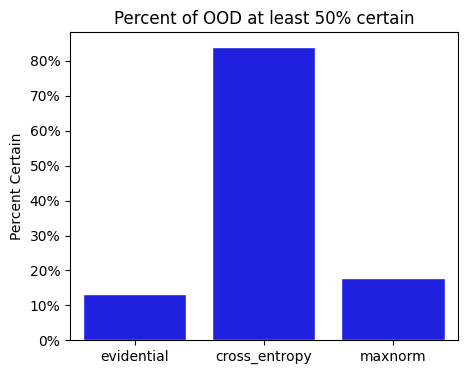

In [17]:
ood_uncertainty_bar_plot(metrics, threshold=0.5)

When using cross entropy, almost 80% of the fashion mnist data is 50% certain or more.  This is for a model train on mnist, not fashion mnist!!   We see the max norm and evidential models are much better at being uncertain about this inputs.

What if we require a much higher degree of certainty.

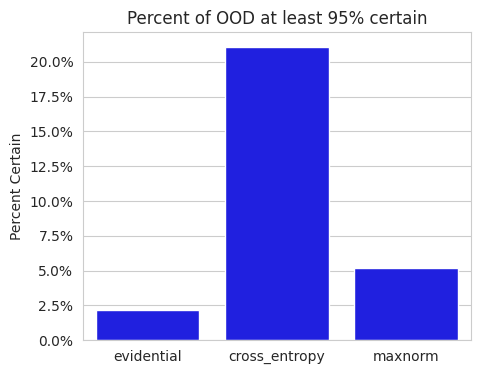

In [18]:
ood_uncertainty_bar_plot(metrics, threshold=0.05)

The cross entropy model is >95% certain for more +20% of the fashion mnist examples!  This is absurd behavior, how can the model be so certain e.g. that a picture of shoe is the digit 5?  In contrast the evidential model and max norm models have much lower percentages of examples that are highly certain from fashion mnist.

Also, note, that in other experiments we have been able to train a maxnorm model to have < 0.09% fashion mnist examples classified as 95% certain or more, or just 9 out of the 10,000 examples in the test set.  We encourage you to experiment with these loss functions to see how well they perform for you. 

------
# Conclusion

In this tutorial we trained 3 models on the MNIST dataset with 3 different loss functions.  All of them had approximately the same accuracy on the test set ~99% but the model trained with evidential and maxnorm loss were much better at detecting out of distribution examples.  The traditional cross entropy model was 95% certain about its predictions on more than 20% of the the *out-of-distribution Fashion MNIST* dataset.  In contrast, the models trained with uncertainty loss were much better at detecting OOD data, for example less than 15% of Fashion MNIST examples had a certainty level of 50% or above, and less than 2% had a certainty level of  95% or above.

Even better, these loss functions don't require any changes to the network architecture and don't have any additional inference cost (compared to other uncertainty methods like Monte Carlo Dropout).  